# Task 2d: Permutated MNIST

Use the provided training set (permutated MNIST) to train your MLP (from task 2b) and your CNN (from task 2c). Apply the both trained models to classify the test set (permutated MNIST). Compare the results with the results from the normal MNIST. Is there a difference from before? If yes, why? Try to explain what you observe with your own words and the reason of this happening.

In [2]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from itertools import product
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from train_tools import TrainHelper
from model_task2c import PR_CNN

In [5]:
# load data
TRAIN_DATASET = "./../data/png/permutated/train"
VALIDATION_DATASET = "./../data/png/permutated/val"
TEST_DATASET = "./../data/png/permutated/test"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.ImageFolder(root=TRAIN_DATASET,
                                     transform=transform)
val_dataset = datasets.ImageFolder(root=VALIDATION_DATASET,
                                     transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DATASET,
                                     transform=transform)

params = {'batch_size': 64,
          'shuffle': True}

train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)
test_loader = torch.utils.data.DataLoader(test_dataset, **params)

In [6]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

## First part: CNN
### Training and finding the best parameters

learning rate: 0.1
Train_loss: 0.148 |                Val_loss: 0.473 |                Train_acc: 95.629 |                Val_acc: 86.394
learning rate: 0.01
Train_loss: 0.308 |                Val_loss: 0.346 |                Train_acc: 91.102 |                Val_acc: 89.727
learning rate: 0.001
Train_loss: 0.589 |                Val_loss: 0.558 |                Train_acc: 85.239 |                Val_acc: 85.778


Best parameters: 0.01 learning_rate and validation accuracies: 89.73%


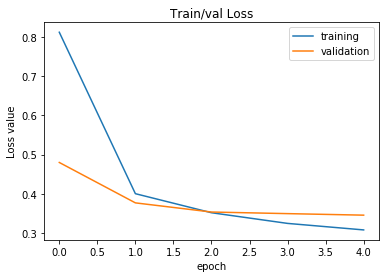

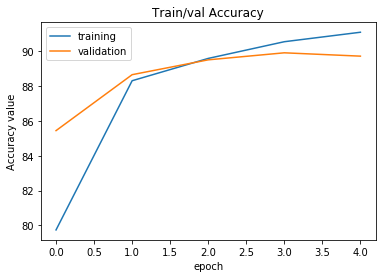

In [4]:
# train CNN
l_rates = [1*10**-i for i in range(1, 4)]
nb_epochs = 5
trainer = TrainHelper(nb_epochs)

# best parameters: (validation acc, learning rate)
best_parameters = (float("-INF"), None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for l_rate in l_rates:
    neural_net = PR_CNN()
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    
    print(f'learning rate: {l_rate}')
    stats_training = trainer.fit(neural_net,
                            train_loader,
                            val_loader,
                            optimizer,
                            loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], l_rate, stats_training)
        best_model = deepcopy(neural_net)

best_acc, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

### Accuracy

In [5]:
# CNN - Test Dataset
loss_test, acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 90.43%


## Second part: MLP

In [7]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, input_):
        #print(input_.shape)
        input_ = input_.view(input_.size(0), -1)
        #print(input_.shape)
        return self.layers(input_)


### Training and finding the best parameters

Hidden dim: 10, learning rate: 0.1
Train_loss: 2.301 |                Val_loss: 2.302 |                Train_acc: 11.157 |                Val_acc: 11.354
Hidden dim: 10, learning rate: 0.01
Train_loss: 0.252 |                Val_loss: 0.351 |                Train_acc: 92.741 |                Val_acc: 90.116
Hidden dim: 10, learning rate: 0.001
Train_loss: 0.370 |                Val_loss: 0.371 |                Train_acc: 89.565 |                Val_acc: 89.540
Hidden dim: 20, learning rate: 0.1
Train_loss: 1.583 |                Val_loss: 1.601 |                Train_acc: 43.990 |                Val_acc: 45.429
Hidden dim: 20, learning rate: 0.01
Train_loss: 0.182 |                Val_loss: 0.223 |                Train_acc: 94.794 |                Val_acc: 93.556
Hidden dim: 20, learning rate: 0.001
Train_loss: 0.342 |                Val_loss: 0.344 |                Train_acc: 90.294 |                Val_acc: 90.056
Hidden dim: 30, learning rate: 0.1
Train_loss: 0.764 |                

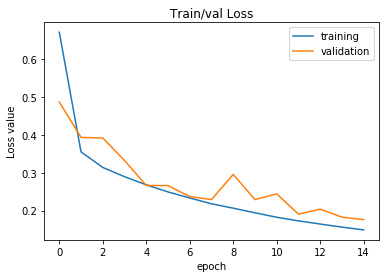

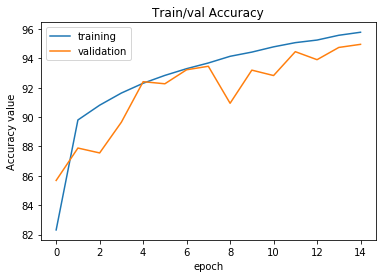

In [8]:
input_dim = 28*28*3
hidden_dims = [i for i in range(10, 101, 10)]
output_dim = 10
l_rates = [1*10**-i for i in range(1, 4)]
nb_epochs = 15
trainer = TrainHelper(nb_epochs)

# best parameters: (validation acc, hidden dim, learning rate)
best_parameters = (float("-INF"), None, None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for hidden_dim, l_rate in product(hidden_dims, l_rates):
    neural_net = NeuralNetwork(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    
    
    print(f'Hidden dim: {hidden_dim}, learning rate: {l_rate}')
    stats_training = trainer.fit(neural_net,
                                 train_loader,
                                 val_loader,
                                 optimizer,
                                 loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], hidden_dim, l_rate, stats_training)
        best_model = deepcopy(neural_net)

best_acc, best_hidden_dim, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_hidden_dim} hidden dim, \
{best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

### Accuracy

In [9]:
# Test dataset
loss_test, acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 95.12%


# Comparison between the normal MNIST set and the permutated one

The accuracy on the test dataset using the best parameters is smaller here (CNN: 90.43%, MLP: 95.12% compared to CNN: 97.75%, MLP: 96.52%). 

The permutated MNIST dataset uses PNG files, whereas the original one uses CSV files. The difference is that the for each of the 28\*28 pixels contained in a single PNG image, we now have 3 different features (red, green, blue). On the other hand, a CSV representation of a digit is based on one feature only (black value). Therefore, the models were more accurate when working with the CSV representations. 

The fact that the images are permutated doesn't make any difference since all images are permutated in the exact same way. In both cases, the models learn a representation of the digits (normal MNIST: human representation, permutated MNIST: permutated representation). 